# Code structure

First, the relevant packages are imported and the code structure is initialized.

In [2]:
import numpy as np
import pandas as pd
import os
import math
import random as rd
import csv
import matplotlib.pyplot as plt
from gurobi import *
from datetime import datetime, timedelta

In [3]:
def readFile(path):
    file = open(path)
    reader = csv.DictReader(file)
    #file.close()
    return reader

In [4]:
class Struct:
    def __init__(self, **args):
        self.__dict__.update(args)

In [5]:
def str_to_timedelta(str_value):
    str_hour_part = str_value.split(' ')[-1].split('.')[0]
    
    time_format = '%H:%M:%S' if str_hour_part.count(":") == 2 else '%H:%M'
    
    time_value = datetime.strptime(str_hour_part, time_format).time()
    return timedelta(hours=time_value.hour,
                            minutes=time_value.minute,
                            seconds=int(time_value.second))

def compute_time(a, b):
    a_timedelta = str_to_timedelta(a) if type(a) == str else a
    b_timedelta = str_to_timedelta(b) if type(b) == str else b
    
    return a_timedelta + b_timedelta

def compute_duration(nb_sec_a, nb_sec_b):
    a_timedelta = timedelta(seconds=float(nb_sec_a))
    b_timedelta = timedelta(seconds=float(nb_sec_b))
    return a_timedelta + b_timedelta

def compute_duration_difference(a, b):
    a_timedelta = str_to_timedelta(a) if type(a) == str else a
    b_timedelta = str_to_timedelta(b) if type(b) == str else b
    
    return a_timedelta - b_timedelta

def adjust_for_midnight(td):
    if td.seconds / 3600 < 4:
        return td + timedelta(seconds=24*3600)
    return td

### Parameters
Next, the parameters of the model are created.

In [6]:
#time restriction for jobs with bike in seconds
pickup_and_delivery_timeout_bike = 1200

#SLA pickup and delivery time restriction in seconds
SLA_time_restrictions = 15  

#5000m radius search to allocate driver to job
gm_radius = 5000

# Definitions
The classes are initiated, i.e. drivers (shifts), jobs, and routes.

### Drivers (i.e. shifts)
The Drivers class gathers the following information about the drivers, i.e. shifts:
- The first definition is a class attribute that collects the drivers/shifts' information provided in the Shifts dataset.
- Then, ∀ *j* ∈ J with job_time *t*, and ∀ *d* ∈ D, **is_working_at_time** checks if *d* is operational at time *t*, i.e. if *t* falls within the shift of driver *d*.
- Finally, ∀ *d* ∈ D, **get_time_table** allows to compute the jobs timetable of *d*. 

In [7]:
class Shift(Struct):
    def __init__(self, disg_shift_id, disg_courier_id, transport, shift_start_time,
                 shift_end_time, starting_loc_id, starting_lon, starting_lat):
        self.disg_shift_id = disg_shift_id
        self.disg_courier_id = disg_courier_id
        self.transport = transport
        self.shift_start_time = str_to_timedelta(shift_start_time)
        self.shift_end_time = str_to_timedelta(shift_end_time)
        
        self.shift_start_time = adjust_for_midnight(self.shift_start_time)
        self.shift_end_time = adjust_for_midnight(self.shift_end_time)
        
        self.starting_loc_id = starting_loc_id
        self.starting_lon = starting_lon
        self.starting_lat = starting_lat
        
        self.current_position = starting_loc_id
        self.arrive_at = self.shift_start_time
        
        self.new_scheduled_jobs = []
        self.old_scheduled_jobs = []

    def is_working_at_time(self, job_time):
        job_time_delta = str_to_timedelta(job_time) if type(job_time) == str else job_time
        job_time_delta = adjust_for_midnight(job_time_delta)
        return self.shift_start_time <= job_time_delta and job_time_delta <= self.shift_end_time
    
    def get_time_table(self):
        res = ''
        for job, route in self.new_scheduled_jobs:
            res += str(job.new_started_at) + ' --> ' + str(job.new_completed_at) + '\n'
        return res

In [8]:
path_shift = 'Shiftsdataforselectedday_2.0.csv'
shifts = [Shift(**row) for row in readFile(path_shift)]

### Orders
The Job class collects the following jobs information:
- The **arrival_time** definition states that, ∀ *r* ∈ R, job *j* ∈ J has an arrival time which depends on *r*.
- The **actual_total_time** property is a more objective total job time. As explained in the text, the actual waiting times of the drivers have been added to the route time estimate from the travel matrix dataset to render the total job time more acurate. 
- The **build_new_times** defines the starting time and the total time of a new job

In [9]:
class Job(Struct):
    def arrival_time(self, route):
        return route.arrival_time(self)
    
    @property
    def actual_total_time(self):
        end_job_time = self.job_completed_at if len(self.job_completed_at) > 0 else self.cancelled_at
        return compute_duration_difference(end_job_time, self.started_at)
    
    def build_new_times(self, new_start, estimated_time):
        self.new_started_at = new_start
        self.new_actual_time = estimated_time
        self.new_completed_at = compute_time(self.new_started_at, estimated_time)

In [10]:
path_job = 'Jobsdataforselectedday_2.0.csv'
jobs = [Job(**row) for row in readFile(path_job)]

### Routes
The Routes class regroups the following routes information:
- The **total_distance** property computes the total distance of a job ∀ *j* ∈ J by adding up the distance from the starting position of driver ∀ *d* ∈ D to the pickup position of *j* with the distance from the pickup of *j* to the drop-off of *j*
- The **total_time** property computes the total time spent on the routes, i.e. start to pick-up, and pick-up to drop-off.
- The **is_authorized** property sets the soft constraints of the model, i.e. the time constraints for SLAs and bike orders and the Genarating Match radius.

In [11]:
class Route(Struct):
    @property
    def total_distance(self):
        return float(self.distance_start_pickup) + float(self.distance_pickup_drop)
    
    @property
    def total_time(self):
        return compute_duration(self.duration_start_pickup, self.duration_pickup_drop)
    
    @property
    def is_authorized(self):
        """if float(self.distance_start_pickup) > gm_radius:
            return False
        if self.MoT.lower() == 'bicycle' \
           and (float(self.duration_start_pickup) > pickup_and_delivery_timeout_bike 
                or float(self.duration_pickup_drop) > pickup_and_delivery_timeout_bike):
            return False
        """
        return True

In [12]:
path_route = 'youri_travel_matrix_2.0.csv'
routes = [Route(**row) for row in readFile(path_route)]

### Heuristic

A heuristic to narrow down the search for the fastest route is applied. To do so, a subsest of routes is created, i.e. **dct_routes_subset**, and for every new job *j* ∈ J, the routes that match the pickup ID of *j* are added to this subset. This helps the system to find the best routes more efficiently as it reduces the number of routes to consider.

In [13]:
dct_routes_subsets = {}
dct_delayed_routes = {}

In [14]:
for route in routes:
    pickup_id = route.pickup_loc_id
    if not pickup_id in dct_routes_subsets:
        dct_routes_subsets[pickup_id] = [route]
    else:
        dct_routes_subsets[pickup_id].append(route)

- **get_actual_started_time** computes the earliest time driver *d* ∈ D can start job *j* ∈ J. It is either the start time of *j* if *d* is currently idle, otherwise, it is the arrival time of *d* at the drop-off location of its current job.

- **compute_arrive_time** computes the arrival time of driver *d* ∈ D at the drop-off location of job *j* ∈ J, given that *d* uses route *r* ∈ R.

In [15]:
def get_actual_started_time(job_start, shift_arrive_at):
    return max(job_start, shift_arrive_at)

def compute_arrive_time(job, shift, route):
    a = str(route.total_time)
    b = get_actual_started_time(str_to_timedelta(job.started_at), shift.arrive_at)

    return compute_time(a, b)

- Given the pickup location ID of job *j* ∈ J and driver *d* ∈ D, **get_route** returns the route selected to complete job *j*. The function ensures the starting location as well as the mode of transport of *d* match with the route's.

- ∀ *j* ∈ J, **get_shift** returns the driver *d* ∈ D selected to complete *j*.  

In [16]:
def get_route(pickup_loc_id, shift):
    for route in dct_routes_subsets[pickup_loc_id]:
        if route.from_loc_id == shift.current_position and route.MoT.lower() == shift.transport.lower():
            return route

def get_shift(job):
    for shift in shifts:
        if shift.disg_courier_id == job.disg_courier_id and shift.is_working_at_time(job.started_at):
            return shift 

# Model

**Algorithm comments**:

**[1]** First,  it checks if there are drivers working at the time t of job *j* ∈ J appears in the system. 
If there are drivers working, they are added to the **available_shifts** list.
However, if there is not a driver available, *j* is added to a list of unsatisfied jobs due to unavailable drivers, i.e. **jobs_with_no_available**.


**[2]** Then, the model searches for the routes of job *j* in the Travel Matrix dataset. 
If the routes of *j* are not found, *j* is added to a list of unsatisfied jobs due to routes not being found, i.e. **job_with_no_route**.
However, if the model finds the routes corresponding to job *j*, and that the routes satisfy the previously defined set of constraints, the routes are selected and equal to **selected_route**.

**[3]** Here, the drop-off time of job *j* is computed using the driver and routes selected above.

**[4]** For every driver in **selected_shift** and every route in **selected_route**, assuming that these satisfy the bike, SLA, and GM radius constraints, the model computes the estimated arrival time of *j* and compares them. 

The smallest arrival time is selected as follows:
If arrival time *n+1* is smaller than arrival time *n*, then the model will use *n+1* as the arrival time of *j* and thus select the corresponding driver and route. This aligns with the objective to minimize the delivery time of each job. 

**[5]** ∀ *j* and *j'* ∈ J and ∀ *d* ∈ D, assuming *d* is assigned to *j*, this condition modifies the starting location of another job *j'* of *d* to be the drop-off location of *j*. 
Additionally, it computes the time at which *d* will be able to start *j'*, by taking the maximum value between the time *j'* appears in the system and the arrival time of *d* at the drop-off location of *j*. In fact, it may be that driver *d* arrives to the drop-off of job *j* before or after being assigned to job *j'*.

**[6]** Recall that the actual delivery times obtained from Quiqup's routing systems have been recalculated using the routes in the Travel Matrix dataset to remove biases in the analysis. 
This part of the code therefore computes these actual delivery times.
Additionally, the actual waiting times recorded by Quiqup for each job have been added to the arrival time computed in **[3]** to compare the delivery times on a similar basis. 

In [17]:
time_saved = timedelta(seconds=0)
waiting_time = timedelta(seconds=0)
not_found_routes = []
not_found_shifts = []
jobs_with_no_route = []
jobs_with_no_available = []

#[1]
for job in jobs[2:]:
    available_shifts = [shift for shift in shifts if shift.is_working_at_time(job.started_at)]
    if len(available_shifts)==0:
        jobs_with_no_available.append(job)
        continue
        
#[2]
    n = 0
    selected_shift = available_shifts[n]
    selected_route = get_route(job.pickup_loc_id, selected_shift)
    
    while selected_route == None:
        n += 1
        if n >= len(available_shifts):
            jobs_with_no_route.append(job)
            break
        selected_shift = available_shifts[n]
        route = get_route(job.pickup_loc_id, selected_shift)
        if not selected_route == None:
            if not route.is_authorized:
                continue
        selected_route = route
     
    if n >= len(available_shifts):
        continue

#[3]
    selected_arrived = compute_arrive_time(job, selected_shift, selected_route)


#[4]
    for shift in available_shifts[n + 1:]:
        shift_route = get_route(job.pickup_loc_id, shift)
        if shift_route == None:
            continue
        elif not shift_route.is_authorized:
            continue
        
        arrived = compute_arrive_time(job, shift, shift_route)
        
        if arrived <= selected_arrived:
            selected_arrived = arrived
            selected_route = shift_route
            selected_shift = shift

#[5]
    selected_shift.current_location = job.drop_loc_id
    selected_shift.new_scheduled_jobs.append((job, selected_route))
    new_started_at = max(str_to_timedelta(job.started_at) 
                         if type(job.started_at) == str else job.started_at,
                         str_to_timedelta(selected_shift.arrive_at) 
                         if type(selected_shift.arrive_at) == str else selected_shift.arrive_at)

#[6]
    selected_route_with_waiting_time = 0
    old_selected_shift = get_shift(job)
    
    if old_selected_shift == None:
        not_found_shifts.append(job)
        selected_shift.arrive_at = compute_time(new_started_at, job.actual_total_time)
        job.build_new_times(new_started_at, job.actual_total_time)
    else:
        old_route = get_route(job.pickup_loc_id, old_selected_shift)
        old_selected_shift.old_scheduled_jobs.append((job, old_route))
        if old_route == None:
            not_found_routes.append(job)
            selected_shift.arrive_at = compute_time(new_started_at, job.actual_total_time)
            job.build_new_times(new_started_at, job.actual_total_time)
        else:
            waiting_time = job.actual_total_time - old_route.total_time
            selected_route_with_waiting_time = selected_route.total_time + waiting_time
            job.build_new_times(new_started_at, selected_route_with_waiting_time)
            selected_shift.arrive_at = compute_time(new_started_at, selected_route_with_waiting_time)
            time_saved += job.actual_total_time - selected_route_with_waiting_time
    
    #print(job.encr_job_id, selected_shift.disg_courier_id, selected_route.id,
    #      job.job_kind, "SLA" if len(job.b2b_delivery_restrictions) > 0 else "", 
    #      selected_shift.transport, selected_route.total_time, selected_route_with_waiting_time)

# Analysis

### Missing data 
- **not_found_routes** are the routes from the Quiqup's actual data that could not be found in the Travel Matrix.
- **not_found_shifts** are the drivers that have been assigned to a job before the start of their shift. It is assumed that these drivers have been assigned manually by Quiqup and thus have been removed by the model as they were not available when recomputing the delivery times of the jobs.
- **jobs_with_no_route** are the jobs whom do not have routes in the Travel Matrix.
- **jobs_with_no_available** are the jobs which can't be satisfied as there is no driver available.

In [18]:
print(len(not_found_routes), 
len(not_found_shifts), 
len(jobs_with_no_route), 
len(jobs_with_no_available)) 

460 22 13 0


### Bike timeout not satisfied

In [19]:
for shift in shifts:
    if shift.transport.lower() == 'bicycle':
        for job, route in shift.new_scheduled_jobs:
            if route.total_time.seconds > 2400:
                print("Bike timeout not satisfied for job" + job.encr_job_id,
                      route.duration_start_pickup, route.duration_pickup_drop, route.total_time.seconds)
            pass

### SLA timeout satisfied (actual data)

In [20]:
n=0
for shift in shifts:
    for job, route in shift.old_scheduled_jobs:
        if job.b2b_delivery_restrictions.lower().endswith('sla'):
            
            if not route==None:
                if job.actual_total_time.seconds <= 1800:
                    n+=1
                pass
            else:
                if job.actual_total_time.seconds <= 1800:
                    n+=1
                pass

print(n)

123


### SLA timeout satisfied (estimate with waiting time)

In [21]:
n=0
for shift in shifts:
    for job, route in shift.new_scheduled_jobs:
        if not route==None:
            
            if job.b2b_delivery_restrictions.lower().endswith('sla'):
                if job.new_actual_time.seconds <= 1800:
                    n+=1
                pass
        else:
            if job.actual_total_time.seconds <= 1800:
                n+=1
            pass
n

130

### SLA timeout satisfied (estimate without waiting time)

In [22]:
n=0
for shift in shifts:
    for job, route in shift.new_scheduled_jobs:
        if not route==None:
            
            if job.b2b_delivery_restrictions.lower().endswith('sla'):
                if route.total_time.seconds <= 1800:
                    n+=1
                pass
print(n)

501


### Time saved

In [23]:
print(time_saved)

10:33:00.900000


### Number of jobs per driver

In [24]:
dict([(len(shift.new_scheduled_jobs), shift.disg_courier_id) for shift in shifts])
s = list(set([int(shft.disg_courier_id) for shft in shifts]))
s.sort()
l = dict([(id, sum([len(shift.new_scheduled_jobs) for shift in shifts if int(shift.disg_courier_id)==id])) for id in s])
print(l)

{1: 2, 2: 3, 3: 12, 4: 17, 5: 10, 6: 0, 7: 11, 8: 4, 9: 12, 10: 17, 11: 6, 12: 7, 13: 6, 14: 8, 15: 10, 16: 4, 17: 2, 18: 0, 19: 0, 20: 14, 21: 1, 22: 0, 23: 6, 24: 16, 25: 5, 26: 0, 27: 0, 28: 17, 29: 9, 30: 0, 31: 9, 32: 0, 33: 0, 34: 3, 35: 14, 36: 0, 37: 18, 38: 7, 39: 2, 40: 3, 41: 3, 42: 4, 43: 6, 44: 4, 45: 4, 46: 2, 47: 5, 48: 7, 49: 5, 50: 10, 51: 0, 52: 0, 53: 11, 54: 1, 55: 8, 56: 11, 57: 0, 58: 4, 59: 5, 60: 7, 61: 2, 62: 13, 63: 4, 64: 7, 65: 4, 66: 1, 67: 4, 68: 3, 69: 4, 70: 2, 71: 5, 72: 0, 73: 1, 74: 0, 75: 4, 76: 0, 77: 2, 78: 3, 79: 9, 80: 0, 81: 3, 82: 6, 83: 0, 84: 6, 85: 8, 86: 0, 87: 6, 88: 6, 89: 11, 90: 0, 91: 5, 92: 0, 93: 8, 94: 0, 95: 6, 96: 0, 97: 14, 98: 1, 99: 14, 100: 0, 101: 4, 102: 8, 103: 4, 104: 2, 105: 9, 106: 0, 107: 15, 108: 5, 109: 1, 110: 0, 111: 13, 112: 10, 113: 5, 114: 3, 115: 3, 116: 0, 117: 4, 118: 0, 119: 6, 120: 0, 121: 11, 122: 7, 123: 0, 124: 5, 125: 1, 126: 6, 127: 6, 128: 1, 129: 0, 130: 5, 131: 7, 132: 2, 133: 1, 134: 2, 135: 2, 136:

### Number of jobs per driver | Estimate vs. Actual

In [25]:
dict([(len(shift.new_scheduled_jobs),shift.disg_courier_id) for shift in shifts])
s = list(set([int(shft.disg_courier_id) for shft in shifts]))
s.sort()
l = dict([(id, (sum([len(shift.new_scheduled_jobs) for shift in shifts if int(shift.disg_courier_id)==id]),
                sum([len(shift.old_scheduled_jobs) for shift in shifts if int(shift.disg_courier_id)==id]))) for id in s])
#print("".join([" ".join([str(i[0]), str(i[1][0]), str(i[1][1])]) + "\n" for i in l.items()]))

### Number of drivers used

In [26]:
print(len(set([shift.disg_courier_id for shift in shifts if len(shift.new_scheduled_jobs)>0])))
print(len(set([shift.disg_courier_id for shift in shifts if len(shift.old_scheduled_jobs)>0])))

168
220


### Jobs done per driver | Estimate vs. Actual
Here shown with driver 1 for example.

In [27]:
driver_id = 1
print([job.encr_job_id for job, route in shifts[driver_id].new_scheduled_jobs])
print(len([job.encr_job_id for job, route in shifts[driver_id].new_scheduled_jobs]))
print(shifts[driver_id].disg_courier_id)

print([job.encr_job_id for job, route in shifts[driver_id].old_scheduled_jobs])
print(len([job.encr_job_id for job, route in shifts[driver_id].old_scheduled_jobs]))
print(shifts[driver_id].disg_courier_id)

['aa161b26e5a1c422b2eabcb155b58c0c', 'e32fd9aee5a6382defb5e12f2a5ebb35', '657fe4431527fa59e6a8fa17a2138871', '1a1e7a1fd65e425e878458d828367619', '51773522f54e9b3f207f4521cf024ce6', '5f2dede02d58d4c96575a828ea820f94', '4c96d89b861e632ea0aeb8eb033ccbc5', '1de4cd2f9008b7ca46359b001f52f408', '18e6c71b5fbf2132adfcbd515e45a4dc', '6fab5a5bbf393d0bf85b9eadff66a820']
10
150
['aa161b26e5a1c422b2eabcb155b58c0c', 'a620bbde44f005d5b4c36060de57e5fb', '60a06f168b084c7c57c4a4a386f09b2e', 'a6253e025fcdc8dd72be13ecf7731c4e', '4d35c37f25e350b982df5687ef63a369']
5
150


### Job time table per driver
Here shown with driver 1 for example.

In [28]:
print(shifts[driver_id].get_time_table())

12:21:05 --> 13:23:15
13:23:30 --> 14:46:19.800000
14:46:19.800000 --> 15:39:29
15:50:46 --> 16:45:01
16:52:06 --> 18:20:34
18:26:25 --> 19:32:45.100000
19:36:59 --> 20:54:28.800000
20:54:28.800000 --> 21:39:05.800000
21:39:05.800000 --> 22:10:51.800000
22:10:51.800000 --> 22:39:11.300000



### Average number of jobs per driver | Estimate vs. Actual

In [29]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

mean(dict([(len(shift.new_scheduled_jobs),shift.disg_courier_id) for shift in shifts]))

7.214285714285714

In [30]:
mean(dict([(len(shift.old_scheduled_jobs),shift.disg_courier_id) for shift in shifts]))

6.384615384615385

### Shift hours saved from Estimate model
This is the number of shift hours saved if drivers that do not have any job are removed from the fleet.

In [31]:
l = [shift for shift in shifts if len(shift.new_scheduled_jobs)==0]
sum([compute_duration_difference(shift.shift_end_time, shift.shift_start_time).seconds for shift in l])/3600

665.3833333333333

### Difference in shift hours saved between Estimate vs. Actual
This is the number of shift hours saved if drivers that do not have any job are removed from the fleet.

In [32]:
l = [shift for shift in shifts if len(shift.new_scheduled_jobs)==0]
snew = sum([compute_duration_difference(shift.shift_end_time, shift.shift_start_time).seconds for shift in l])/3600

l = [shift for shift in shifts if len(shift.old_scheduled_jobs)==0]
sold = sum([compute_duration_difference(shift.shift_end_time, shift.shift_start_time).seconds for shift in l])/3600

snew-sold

467.29999999999995

### Number of active drivers by 30-minute period (i.e. drivers that have had a job within that period)
### Real vs. Estimate vs. Actual

In [33]:
def job_in_period(time_start, time_end, job):
    started_at = str_to_timedelta(job.started_at)
    completed_at = str_to_timedelta(job.job_completed_at) if len(job.job_completed_at)>0 else str_to_timedelta(job.cancelled_at)
    
    started_at = adjust_for_midnight(started_at)
    completed_at = adjust_for_midnight(completed_at)
    return (started_at > time_start and started_at < time_end) or (completed_at > time_start and completed_at < time_end)

dct_tot = {}
for i in range(8*3600, 24*3600, 1800):
    td = timedelta(seconds=i)
    dct_tot[int(td.seconds)] = len([shift for shift in shifts if shift.is_working_at_time(td + timedelta(seconds=0.25*3600))])

for i in range(24*3600, 26*3600, 1800):
    td = timedelta(seconds=i)
    dct_tot[int(td.seconds)] = len([shift for shift in shifts if shift.is_working_at_time(td - timedelta(seconds=24*3600) + timedelta(seconds=0.25*3600))])

dct_new = {}
for i in range(8*3600, 24*3600, 1800):
    td = timedelta(seconds=i)
    dct_new[int(td.seconds)] = len([shift for shift in shifts if 
        len([job for job, route in shift.new_scheduled_jobs if job_in_period(td, td + timedelta(seconds=1800), job)])>0])
    
for i in range(24*3600, 26*3600, 1800):
    td = timedelta(seconds=i)
    dct_new[int(td.seconds)] = len([shift for shift in shifts if 
        len([job for job, route in shift.new_scheduled_jobs if job_in_period(td, td + timedelta(seconds=1800), job)])>0])

dct_old = {}
for i in range(8*3600, 24*3600, 1800):
    td = timedelta(seconds=i)
    dct_old[int(td.seconds)] = len([shift for shift in shifts if 
        len([job for job, route in shift.old_scheduled_jobs if job_in_period(td, td + timedelta(seconds=1800), job)])>0])
    
for i in range(24*3600, 26*3600, 1800):
    td = timedelta(seconds=i)
    dct_old[int(td.seconds)] = len([shift for shift in shifts if 
        len([job for job, route in shift.old_scheduled_jobs if job_in_period(td, td + timedelta(seconds=1800), job)])>0])

l=[int(i) for i in list(dct_new.keys())]
l.sort()
l = [(timedelta(seconds=s), dct_tot[s], dct_new[s], dct_old[s]) for s in l]
print("".join([" ".join([str(i[0]), str(i[1]), str(i[2]), str(i[3]), str(i[3]-i[2])]) + "\n" for i in l]))
x = [i[0].seconds/3600 for i in l]
y1_act = [i[1] for i in l]
y2_act = [i[2] for i in l]
y3_act = [i[3] for i in l]

0:00:00 18 3 3 0
0:30:00 17 4 5 1
1:00:00 17 1 1 0
1:30:00 0 0 0 0
8:00:00 25 4 4 0
8:30:00 27 6 6 0
9:00:00 29 10 8 -2
9:30:00 31 9 9 0
10:00:00 40 14 15 1
10:30:00 41 17 19 2
11:00:00 48 20 19 -1
11:30:00 48 16 15 -1
12:00:00 136 51 49 -2
12:30:00 141 49 58 9
13:00:00 139 51 60 9
13:30:00 140 56 66 10
14:00:00 142 55 65 10
14:30:00 140 54 66 12
15:00:00 136 58 65 7
15:30:00 132 47 55 8
16:00:00 133 68 71 3
16:30:00 132 55 60 5
17:00:00 181 75 82 7
17:30:00 186 68 75 7
18:00:00 192 80 90 10
18:30:00 188 63 74 11
19:00:00 190 68 81 13
19:30:00 190 75 97 22
20:00:00 177 80 94 14
20:30:00 174 70 83 13
21:00:00 123 77 87 10
21:30:00 112 69 71 2
22:00:00 61 46 59 13
22:30:00 39 38 33 -5
23:00:00 26 20 25 5
23:30:00 22 8 8 0



### Number of inactive drivers by 30-minute period (i.e. drivers that have not had a job within that period)
### Real vs. Estimate vs. Actual

In [34]:
def job_in_period(time_start, time_end, job):
    started_at = str_to_timedelta(job.started_at)
    completed_at = str_to_timedelta(job.job_completed_at) if len(job.job_completed_at)>0 else str_to_timedelta(job.cancelled_at)
    
    started_at = adjust_for_midnight(started_at)
    completed_at = adjust_for_midnight(completed_at)
    return (started_at > time_start and started_at < time_end) or (completed_at > time_start and completed_at < time_end)

dct_tot = {}
for i in range(8*3600, 24*3600, 1800):
    td = timedelta(seconds=i)
    dct_tot[int(td.seconds)] = len([shift for shift in shifts if shift.is_working_at_time(td + timedelta(seconds=0.25*3600))])

for i in range(24*3600, 26*3600, 1800):
    td = timedelta(seconds=i)
    dct_tot[int(td.seconds)] = len([shift for shift in shifts if shift.is_working_at_time(td - timedelta(seconds=24*3600) + timedelta(seconds=0.25*3600))])

dct_new = {}
for i in range(8*3600, 24*3600, 1800):
    td = timedelta(seconds=i)
    working_drivers = len([shift for shift in shifts if shift.is_working_at_time(td + timedelta(seconds=0.25*3600))])
    occupied_drivers = len([shift for shift in shifts if 
        len([job for job, route in shift.new_scheduled_jobs if job_in_period(td, td + timedelta(seconds=1800), job)])>0])
    dct_new[int(td.seconds)] = working_drivers - occupied_drivers
    
for i in range(24*3600, 26*3600, 1800):
    td = timedelta(seconds=i)
    working_drivers = len([shift for shift in shifts if shift.is_working_at_time(td - timedelta(seconds=24*3600) + timedelta(seconds=0.25*3600))])
    occupied_drivers = len([shift for shift in shifts if 
        len([job for job, route in shift.new_scheduled_jobs if job_in_period(td, td + timedelta(seconds=1800), job)])>0])
    dct_new[int(td.seconds)] = working_drivers - occupied_drivers

dct_old = {}
for i in range(8*3600, 24*3600, 1800):
    td = timedelta(seconds=i)
    working_drivers = len([shift for shift in shifts if shift.is_working_at_time(td + timedelta(seconds=0.25*3600))])
    occupied_drivers = len([shift for shift in shifts if 
        len([job for job, route in shift.old_scheduled_jobs if job_in_period(td, td + timedelta(seconds=1800), job)])>0])
    dct_old[int(td.seconds)] = working_drivers - occupied_drivers
    
for i in range(24*3600, 26*3600, 1800):
    td = timedelta(seconds=i)
    working_drivers = len([shift for shift in shifts if shift.is_working_at_time(td - timedelta(seconds=24*3600) + timedelta(seconds=0.25*3600))])
    occupied_drivers = len([shift for shift in shifts if 
        len([job for job, route in shift.old_scheduled_jobs if job_in_period(td, td + timedelta(seconds=1800), job)])>0])
    dct_old[int(td.seconds)] = working_drivers - occupied_drivers

l=[int(i) for i in list(dct_new.keys())]
l.sort()
l = [(timedelta(seconds=s), dct_tot[s], dct_new[s], dct_old[s]) for s in l]
print("".join([" ".join([str(i[0]), str(i[1]), str(i[2]), str(i[3]), str(i[3]-i[2])]) + "\n" for i in l]))
x = [i[0].seconds/3600 for i in l]
y1_inact = [i[1] for i in l]
y2_inact = [i[2] for i in l]
y3_inact = [i[3] for i in l]



0:00:00 18 15 15 0
0:30:00 17 13 12 -1
1:00:00 17 16 16 0
1:30:00 0 0 0 0
8:00:00 25 21 21 0
8:30:00 27 21 21 0
9:00:00 29 19 21 2
9:30:00 31 22 22 0
10:00:00 40 26 25 -1
10:30:00 41 24 22 -2
11:00:00 48 28 29 1
11:30:00 48 32 33 1
12:00:00 136 85 87 2
12:30:00 141 92 83 -9
13:00:00 139 88 79 -9
13:30:00 140 84 74 -10
14:00:00 142 87 77 -10
14:30:00 140 86 74 -12
15:00:00 136 78 71 -7
15:30:00 132 85 77 -8
16:00:00 133 65 62 -3
16:30:00 132 77 72 -5
17:00:00 181 106 99 -7
17:30:00 186 118 111 -7
18:00:00 192 112 102 -10
18:30:00 188 125 114 -11
19:00:00 190 122 109 -13
19:30:00 190 115 93 -22
20:00:00 177 97 83 -14
20:30:00 174 104 91 -13
21:00:00 123 46 36 -10
21:30:00 112 43 41 -2
22:00:00 61 15 2 -13
22:30:00 39 1 6 5
23:00:00 26 6 1 -5
23:30:00 22 14 14 0



### Graph: Difference in inactive drivers between Estimate and Actual data 

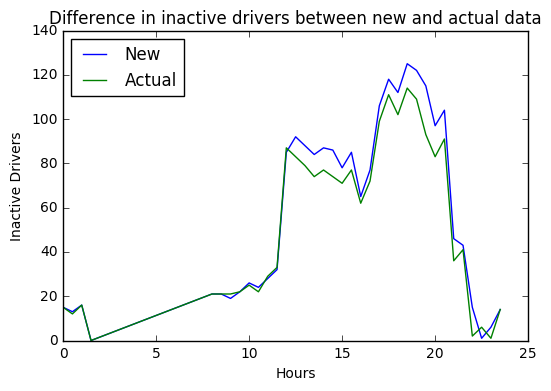

In [35]:
plt.plot(x, y2_inact, label="New")
plt.plot(x, y3_inact, label="Actual")
plt.xlabel("Hours")
plt.ylabel("Inactive Drivers")
plt.title("Difference in inactive drivers between new and actual data")
plt.legend(loc='best')
plt.show()

### Graph: Difference in active drivers between Estimate and Actual data  

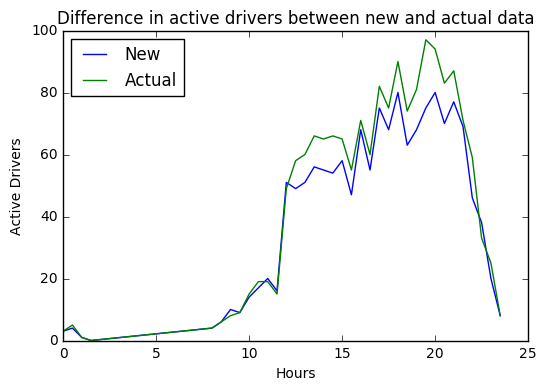

In [36]:
plt.plot(x, y2_act, label="New")
plt.plot(x, y3_act, label="Actual")
plt.xlabel("Hours")
plt.ylabel("Active Drivers")
plt.title("Difference in active drivers between new and actual data")
plt.legend(loc='best')
plt.show()